## Linear Regression Modelling Project

This project was inspired by a Udemy online course on regression and forecasting techniques in data science.

We have a cleaned dataset of rent prices in San Francisco provided by Udemy and the goal is to build a linear regression model that can accurately predict the rent price of an apartment based on the given variables.

A reasonable goal, as set by Udemy, is to get the MAE of the final model to around 500 dollars.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae

rentals_df = pd.read_csv("../Data/sf_clean.csv") 
rentals_df.head(10)

C:\Users\justi\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\justi\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0
5,3800,800.0,2.0,1.0,(b) on-site,(c) cats,(c) multi,(b) protected,9.0
6,3100,750.0,1.0,1.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,8.0
7,3000,650.0,1.0,1.0,(b) on-site,(a) both,(c) multi,(d) no parking,7.0
8,3000,650.0,1.0,1.0,(b) on-site,(a) both,(c) multi,(b) protected,7.0
9,3200,650.0,1.0,1.0,(a) in-unit,(c) cats,(c) multi,(b) protected,9.0


### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

## EDA


In [2]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


In [3]:
rentals_df.describe()

,price,sqft,beds,bath,hood_district
count,989.000000,989.000000,989.000000,989.000000,989.000000
mean,3595.035389,976.765420,1.679474,1.390293,7.052578
std,1546.222670,474.629798,1.076710,0.562714,2.404716
min,750.000000,150.000000,0.000000,1.000000,1.000000
25%,2650.000000,650.000000,1.000000,1.000000,6.000000
50%,3300.000000,900.000000,2.000000,1.000000,8.000000
75%,4242.000000,1200.000000,2.000000,2.000000,9.000000
max,19000.000000,3500.000000,6.000000,4.000000,10.000000


In [4]:
rentals_df.corr(numeric_only=True)

,price,sqft,beds,bath,hood_district
price,1.000000,0.835834,0.673328,0.691190,0.013010
sqft,0.835834,1.000000,0.765070,0.720929,-0.038425
beds,0.673328,0.765070,1.000000,0.629331,-0.109195
bath,0.691190,0.720929,0.629331,1.000000,0.022967
hood_district,0.013010,-0.038425,-0.109195,0.022967,1.000000


Initial correlation exploration shows fair correlation of price with sqft, beds, bath.

<AxesSubplot:xlabel='price', ylabel='Count'>

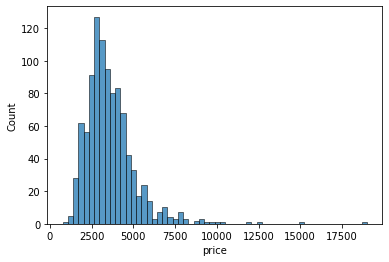

In [5]:
sns.histplot(rentals_df['price'])

<AxesSubplot:xlabel='price', ylabel='Count'>

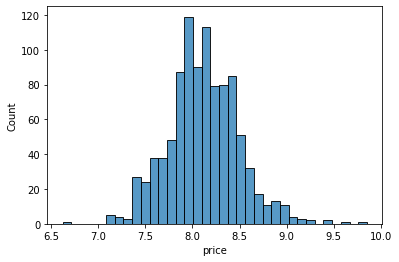

In [6]:
from scipy import stats

boxcox, calc_lambda = stats.boxcox(rentals_df['price'])
sns.histplot(np.log(rentals_df['price']))

<AxesSubplot:ylabel='Count'>

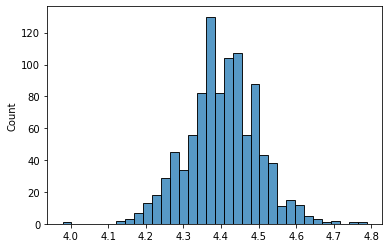

In [7]:
sns.histplot(boxcox)

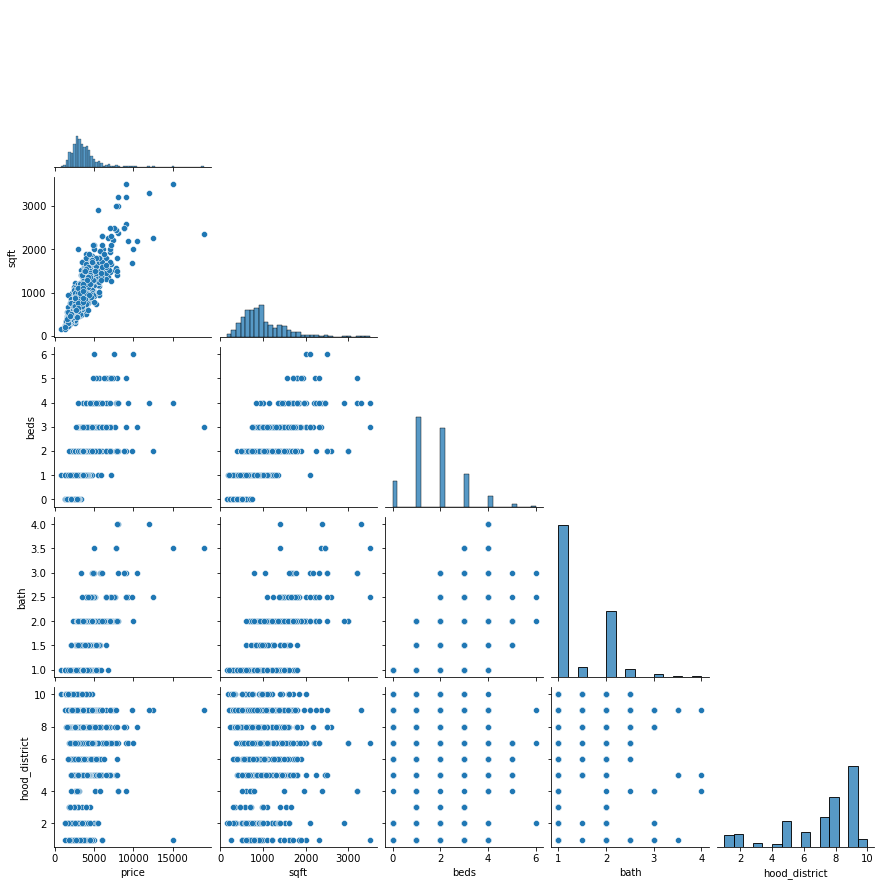

In [8]:
sns.pairplot(rentals_df, corner=True)

In [9]:
for column in rentals_df.select_dtypes('object'):
    print("Column: " + f"{rentals_df[column].value_counts()}")
print("Column: " + f"{rentals_df['hood_district'].value_counts()}")

Column: laundry
(a) in-unit       488
(b) on-site       370
(c) no laundry    131
Name: count, dtype: int64
Column: pets
(d) no pets    510
(a) both       367
(c) cats        91
(b) dogs        21
Name: count, dtype: int64
Column: housing_type
(c) multi     937
(a) single     40
(b) double     12
Name: count, dtype: int64
Column: parking
(d) no parking    478
(b) protected     439
(c) off-street     38
(a) valet          34
Name: count, dtype: int64
Column: hood_district
9.0     332
8.0     207
7.0     123
5.0     106
6.0      62
2.0      51
1.0      50
10.0     33
3.0      14
4.0      11
Name: count, dtype: int64


<AxesSubplot:title={'center':'median'}, xlabel='hood_district'>

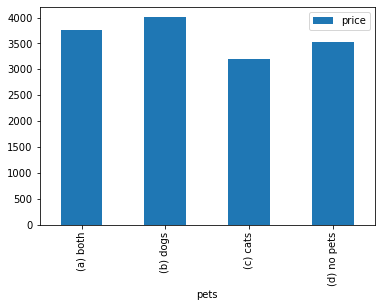

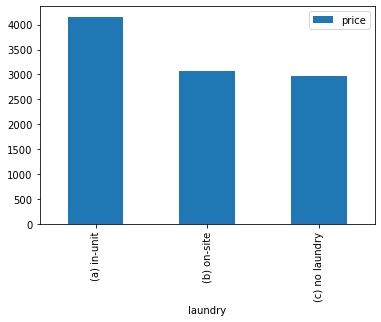

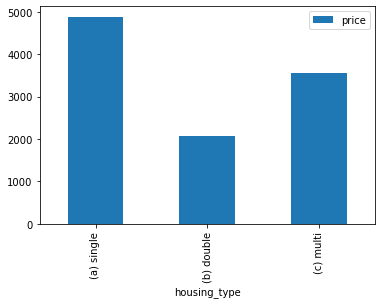

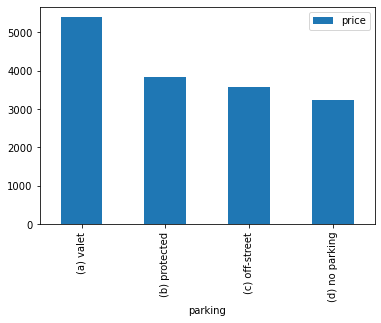

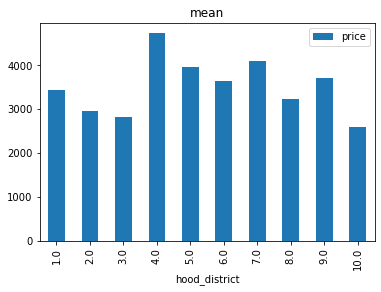

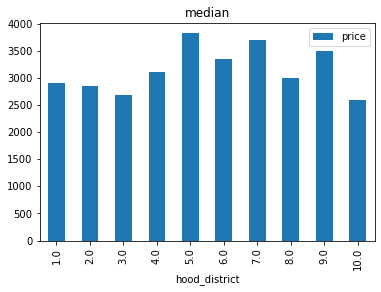

In [10]:
rentals_df.groupby('pets').agg({'price' : 'mean'}).plot.bar()
rentals_df.groupby('laundry').agg({'price' : 'mean'}).plot.bar()
rentals_df.groupby('housing_type').agg({'price' : 'mean'}).plot.bar()
rentals_df.groupby('parking').agg({'price' : 'mean'}).plot.bar()
rentals_df.groupby('hood_district').agg({'price' : 'mean'}).plot.bar(title='mean')
rentals_df.groupby('hood_district').agg({'price' : 'median'}).plot.bar(title='median')

Housing types can remain as 3 separate categories with clear price difference between each category. Laundry and parking can be reduced down to binary categories, in-unit or not and valet or not respectively. No pets and both pets do not seem to make too much of a difference in price while the difference between dogs allowed and cats allowed is more pronounced. This could be simplified to dogs or no dogs.

For hood_district, there seems to be fairly significant differences in price per sector and sector 11 is not in the dataset. Sectors 2, 3, 10 are on average the lowest priced districts and Twin Peaks is the highest priced sector on average. Comparing to the median, it seems that sectors 5, 6, 7, 8, and 9 are fairly consistent in terms of price ranking. Could separate 5, 6, 7, 8, 9 into one common group and the rest into their own group. Twin Peaks and Southwest have very few data points so even though Twin Peaks mean is very high, it is probably due to outliers since its median ranks very low among sectors.

![image info](SFAR_map.png)

## Feature Engineering


In [11]:
df_mod = rentals_df.assign(
    valet = np.where(rentals_df['parking'] == '(a) valet', 1, 0),
    in_unit_laundry = np.where(rentals_df['laundry'] == '(a) in-unit', 1, 0),
    dogs = np.where((rentals_df['pets'] == '(a) both') | (rentals_df['pets'] == '(b) dogs'), 1, 0),
    northeast = np.where((rentals_df['hood_district'] == 5) | (rentals_df['hood_district'] == 6) | (rentals_df['hood_district'] == 7) | (rentals_df['hood_district'] == 8) | (rentals_df['hood_district'] == 9), 1, 0),
    beds_bath = rentals_df['beds'] + rentals_df['bath'],
    sqft2 = rentals_df['sqft']**2,
    sqft3 = rentals_df['sqft']**3,
    beds_bath2 = (rentals_df['beds'] + rentals_df['bath'])**2
).drop([
    'laundry',
    'parking',
    'pets',
    'hood_district',
    'beds',
#     'sqft',
    'bath'
], axis=1)

df_mod=pd.get_dummies(df_mod, drop_first=True, dtype=int)
df_mod.head()

,price,sqft,valet,in_unit_laundry,dogs,northeast,beds_bath,sqft2,sqft3,beds_bath2,housing_type_(b) double,housing_type_(c) multi
0,6800,1600.0,0,1,0,1,4.0,2560000.0,4.096000e+09,16.00,0,1
1,3500,550.0,0,1,1,1,2.0,302500.0,1.663750e+08,4.00,0,1
2,5100,1300.0,0,1,1,1,3.0,1690000.0,2.197000e+09,9.00,0,1
3,9000,3500.0,0,1,0,1,5.5,12250000.0,4.287500e+10,30.25,0,1
4,3100,561.0,0,0,1,1,2.0,314721.0,1.765585e+08,4.00,0,1


In [12]:
df_mod.corr()

,price,sqft,valet,in_unit_laundry,dogs,northeast,beds_bath,sqft2,sqft3,beds_bath2,housing_type_(b) double,housing_type_(c) multi
price,1.000000,0.835834,0.220353,0.360382,0.092655,0.127518,0.744511,0.801532,0.709794,0.732352,-0.109943,-0.097273
sqft,0.835834,1.000000,0.097774,0.298605,0.062188,-0.003124,0.821717,0.948022,0.827640,0.800637,-0.102134,-0.173378
valet,0.220353,0.097774,1.000000,0.168982,0.030248,0.082584,0.037585,0.087280,0.068074,0.021455,-0.020911,0.044450
in_unit_laundry,0.360382,0.298605,0.168982,1.000000,0.263227,0.200718,0.273800,0.246372,0.189499,0.241928,-0.072434,-0.003097
dogs,0.092655,0.062188,0.030248,0.263227,1.000000,0.143076,0.076067,0.048331,0.035881,0.058105,-0.070133,0.105777
northeast,0.127518,-0.003124,0.082584,0.200718,0.143076,1.000000,-0.032963,-0.039854,-0.062586,-0.053578,-0.253212,0.377900
beds_bath,0.744511,0.821717,0.037585,0.273800,0.076067,-0.032963,1.000000,0.720491,0.573766,0.965788,-0.066929,-0.145026
sqft2,0.801532,0.948022,0.087280,0.246372,0.048331,-0.039854,0.720491,1.000000,0.960100,0.746791,-0.070420,-0.214661
sqft3,0.709794,0.827640,0.068074,0.189499,0.035881,-0.062586,0.573766,0.960100,1.000000,0.628215,-0.045904,-0.225215
beds_bath2,0.732352,0.800637,0.021455,0.241928,0.058105,-0.053578,0.965788,0.746791,0.628215,1.000000,-0.063492,-0.162261


## Data Splitting

In [13]:
from sklearn.model_selection import train_test_split

features = [
    'sqft',
    'sqft2',
#     'sqft3',
#     'beds',
#     'bath',
    'beds_bath',
#     'beds_bath2',
    'valet',
    'in_unit_laundry',
#     'dogs',
    'northeast',
#     'housing_type_(b) double',
#     'housing_type_(c) multi'
]
X = sm.add_constant(df_mod[features])
# y = np.log(df_mod["price"])
y = pd.DataFrame({'price': boxcox})

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2025)

## Model Fitting & Validation Scoring

In [14]:
from scipy.special import inv_boxcox

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=2025)

cv_r2 = []
cv_mae = []

for train_i, val_i in kf.split(X,y):
    X_train, y_train = X.iloc[train_i], y.iloc[train_i]
    X_val, y_val = X.iloc[val_i], y.iloc[val_i]
    model = sm.OLS(y_train, X_train).fit()
    cv_r2.append(r2(y_val, model.predict(X_val)))
    cv_mae.append(mae(inv_boxcox(y_val, calc_lambda), inv_boxcox(model.predict(X_val), calc_lambda)))
    
print("All Validation R2s: ", [round(x, 3) for x in cv_r2])
print(f"Cross Val R2s: {round(np.mean(cv_r2), 3)} +- {round(np.std(cv_r2), 3)}")

print("All Validation MAEs: ", [round(x, 3) for x in cv_mae])
print(f"Cross Val MAEs: {round(np.mean(cv_mae), 3)} +- {round(np.std(cv_mae), 3)}")  

All Validation R2s:  [0.77, 0.709, 0.854, 0.767, 0.805]
Cross Val R2s: 0.781 +- 0.048
All Validation MAEs:  [523.385, 591.239, 514.271, 496.016, 500.742]
Cross Val MAEs: 525.131 +- 34.449


In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     392.9
Date:                Thu, 25 Sep 2025   Prob (F-statistic):          1.68e-208
Time:                        17:49:11   Log-Likelihood:                 1073.1
No. Observations:                 633   AIC:                            -2132.
Df Residuals:                     626   BIC:                            -2101.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.1445      0.008    520.527      0.000       4.129       4.160
sqft                0.0002   1.49e-05     14.582      0.000       0.000       0.000
sqft2           -3.468e-08   4.19e-09     -8.269      0.000   -4.29e-08   -2.64e-08
beds_bath           0.0142      0.002      6.613      0.000       0.010       0.018
valet               0.0399      0.010      3.860      0.000       0.020       0.060
in_unit_laundry     0.0192      0.004      4.960      0.000       0.012       0.027
northeast           0.0406      0.005      8.104      0.000       0.031       0.050
==============================================================================
Omnibus:                       20.690   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.426
Skew:                          -0.240   Prob(JB):                     3.35e-08
Kurtosis:                       4.036   Cond. No.                     1.08e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Assumptions Checking

Durbin-Watson in model summary very close to 2 so errors are independent of each other.

In [17]:
def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    residuals = model.resid
    
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0], alpha=.3)
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")   


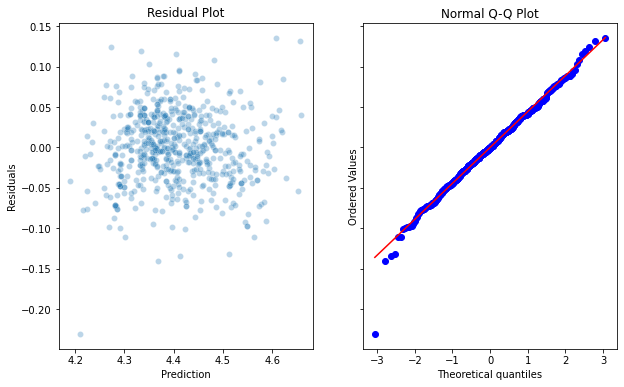

In [18]:
residual_analysis_plots(model)

Residuals seem to be normally distributed with roughly equal variance.

In [19]:
influence = model.get_influence()
inf_summary_df = influence.summary_frame()

In [20]:
inf_summary_df["cooks_d"].sort_values(ascending=False).head()

11     0.349126
56     0.106682
253    0.090052
602    0.036065
561    0.028063
Name: cooks_d, dtype: float64

No influential points detected (Cook's D < 0.5)

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

variables = sm.OLS(y, X).exog

pd.Series(
    [vif(variables, i) for i in range(variables.shape[1])],
    index=X.columns
)

const              19.671697
sqft               16.788734
sqft2              11.114780
beds_bath           3.492738
valet               1.040238
in_unit_laundry     1.197155
northeast           1.073007
dtype: float64

All VIFs, disregarding multiple polynomial terms, are below 5 so there is no perfect multicollinearity present.

## Final Model Fit & Test Scoring

In [22]:
print(f"Test R2: {r2(y_test, model.predict(X_test))}")
print(f"Test MAE: {mae(inv_boxcox(y_test, calc_lambda), inv_boxcox(model.predict(X_test), calc_lambda))}")

Test R2: 0.7894811327873623
Test MAE: 433.5932595529336


# Regularized Regression Models

Exploring Ridge, Lasso, and ElasticNet regression models that predict the `price` column in the dataset on San Francisco Apartment rentals. These models build off of simple linear regression and improve by preventing overfitting during the training phase. They also allow for more freedom when it comes to expanding the list of model features since the algorithm will help prevent overfitting and this will hopefully result in a better predictive model.

In [23]:
rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

## Feature Engineering

In [24]:
df_mod = rentals_df.assign(
    valet = np.where(rentals_df['parking'] == '(a) valet', 1, 0),
    in_unit_laundry = np.where(rentals_df['laundry'] == '(a) in-unit', 1, 0),
    dogs = np.where((rentals_df['pets'] == '(a) both') | (rentals_df['pets'] == '(b) dogs'), 1, 0),
    northeast = np.where((rentals_df['hood_district'] == 5) | (rentals_df['hood_district'] == 6) | (rentals_df['hood_district'] == 7) | (rentals_df['hood_district'] == 8) | (rentals_df['hood_district'] == 9), 1, 0),
    beds_bath = rentals_df['beds'] + rentals_df['bath'],
    sqft2 = rentals_df['sqft']**2,
    sqft3 = rentals_df['sqft']**3,
    beds_bath2 = (rentals_df['beds'] + rentals_df['bath'])**2,
    beds2 = rentals_df['beds']**2,
    beds3 = rentals_df['beds']**3,
    bath2 = rentals_df['bath']**2,
    bath3 = rentals_df['bath']**3
).drop([
    'laundry',
    'parking',
    'pets',
    'hood_district',
#     'beds',
# #     'sqft',
#     'bath'
], axis=1)

df_mod=pd.get_dummies(df_mod, drop_first=True, dtype=int)
df_mod.head()

,price,sqft,beds,bath,valet,in_unit_laundry,dogs,northeast,beds_bath,sqft2,sqft3,beds_bath2,beds2,beds3,bath2,bath3,housing_type_(b) double,housing_type_(c) multi
0,6800,1600.0,2.0,2.0,0,1,0,1,4.0,2560000.0,4.096000e+09,16.00,4.0,8.0,4.00,8.000,0,1
1,3500,550.0,1.0,1.0,0,1,1,1,2.0,302500.0,1.663750e+08,4.00,1.0,1.0,1.00,1.000,0,1
2,5100,1300.0,2.0,1.0,0,1,1,1,3.0,1690000.0,2.197000e+09,9.00,4.0,8.0,1.00,1.000,0,1
3,9000,3500.0,3.0,2.5,0,1,0,1,5.5,12250000.0,4.287500e+10,30.25,9.0,27.0,6.25,15.625,0,1
4,3100,561.0,1.0,1.0,0,0,1,1,2.0,314721.0,1.765585e+08,4.00,1.0,1.0,1.00,1.000,0,1


## Data Splitting

In [25]:
from sklearn.model_selection import train_test_split
from scipy import stats

boxcox, calc_lambda = stats.boxcox(rentals_df['price'])

features = [
    'sqft',
    'sqft2',
    'sqft3',
    'beds_bath',
    'beds_bath2',
    'beds',
    'beds2',
    'beds3',
    'bath',
    'bath2',
    'bath3',
    'valet',
    'in_unit_laundry',
    'dogs',
    'northeast',
    'housing_type_(b) double',
    'housing_type_(c) multi'
]
X = sm.add_constant(df_mod[features])
y = pd.DataFrame({'price': boxcox})

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2025)

## Scaling Data

In [26]:
import scipy
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

X_train = std.fit_transform(X.values)
X_test = std.transform(X_test.values)

## Ridge

In [27]:
from sklearn.linear_model import RidgeCV
from scipy.special import inv_boxcox

n = 200
alphas = 10 ** np.linspace(-3,3,n)

ridge_model = RidgeCV(alphas=alphas, cv=5)
ridge_model.fit(X_train, y)

print(f"Alpha: {ridge_model.alpha_}")
print(f"Train R2: {ridge_model.score(X_train, y)}")
print(f"Test R2: {ridge_model.score(X_test, y_test)}")
print(f"Test MAE: {mae(inv_boxcox(y_test, calc_lambda), inv_boxcox(ridge_model.predict(X_test), calc_lambda))}")

Alpha: 0.12033778407775893
Train R2: 0.8180272349549914
Test R2: 0.792305277492612
Test MAE: 437.88351290029016


## Lasso

In [28]:
from sklearn.linear_model import LassoCV

lasso_model = LassoCV(alphas=alphas, cv=5)
lasso_model.fit(X_train, y)

print(f"Alpha: {lasso_model.alpha_}")
print(f"Train R2: {lasso_model.score(X_train, y)}")
print(f"Test R2: {lasso_model.score(X_test, y_test)}")
print(f"Test MAE: {mae(inv_boxcox(y_test, calc_lambda), inv_boxcox(lasso_model.predict(X_test), calc_lambda))}")

list(zip(X.columns, lasso_model.coef_))

Alpha: 0.001
Train R2: 0.7947224498510712
Test R2: 0.7995592742778589
Test MAE: 423.8140164343033


C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('const', 0.0),
 ('sqft', 0.06340605942738088),
 ('sqft2', -0.0),
 ('sqft3', -0.012249066714108362),
 ('beds_bath', 0.004815608214494796),
 ('beds_bath2', -0.0),
 ('beds', 0.030348397940118708),
 ('beds2', -0.0),
 ('beds3', -0.013112089488418204),
 ('bath', 0.0),
 ('bath2', 0.0),
 ('bath3', 0.0041136797911921095),
 ('valet', 0.006780550063066005),
 ('in_unit_laundry', 0.009971302407655851),
 ('dogs', 0.0012842688049688109),
 ('northeast', 0.013500528795344323),
 ('housing_type_(b) double', -0.0015675430834892836),
 ('housing_type_(c) multi', -0.0)]

## ENET

In [29]:
from sklearn.linear_model import ElasticNetCV

enet_model = ElasticNetCV(alphas=alphas, l1_ratio=np.arange(0.1,1,20), cv=5)
enet_model.fit(X_train, y)

print(f"Alpha: {enet_model.alpha_}")
print(f"L1 Ratio: {enet_model.l1_ratio_}")
print(f"Train R2: {enet_model.score(X_train, y)}")
print(f"Test R2: {enet_model.score(X_test, y_test)}")
print(f"Test MAE: {mae(inv_boxcox(y_test, calc_lambda), inv_boxcox(enet_model.predict(X_test), calc_lambda))}")

C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Alpha: 0.001
L1 Ratio: 0.1
Train R2: 0.8125364054639916
Test R2: 0.7984821424287882
Test MAE: 430.27179682396326


## Final Model Test

From the model test scores above, we can conclude that the lasso model is the best with a test R2 value of 0.7995592742778589 and a test MAE value of 423.8140164343033. This is also better than the multiple linear regression model which has a test R2 value of 0.7894811327873623 and a test MAE value of 433.5932595529336.